In [9]:
from urllib.request import urlopen
from Bio.PDB import PDBParser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
np.set_printoptions(threshold=np.inf)

In [71]:
def fetch_pdb_files(pdb_id, output_dir="."):
  if len(pdb_id) != 4:
    raise ValueError(f"PDB ID must be 4 characters: {pdb_id}")
  os.makedirs(output_dir, exist_ok=True)
  try:
    response = urlopen(f"https://files.rcsb.org/download/{pdb_id}.pdb")
    pdb = response.read().decode("utf-8", "ignore")
    with open(os.path.join(output_dir, f"{pdb_id}.pdb"), "w") as f:
      f.write(pdb)
    print(f"{pdb_id}.pdb saved in /{output_dir} successfully")
  except:
    print("Error: PDB could not be downloaded")
    pass


# def euclidean_distance(residue_one, residue_two):
#     """
#     input: takes 2 residues
#     output: euclidean distance of 2 Central Alpha atoms
#     """
#     diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
#     return np.sqrt(np.sum(diff_vector **2))


# def distance_matrix(chain_one, chain_two, seqlength):
  #ca_coords = np.array([atom.get_coord() for residue in model[chain] for atom in residue if atom.get_name() == "CA"])
#     answer = np.zeros([seqlength, seqlength])
#     for row, residue_one in enumerate(chain_one):
#         for col, residue_two in enumerate(chain_two):
#             if max(col, row) >= seqlength:
#                 break
#             answer[row, col] = euclidean_distance(residue_one, residue_two)
#     return answer

def distance_matrix(model, chain, seqlength, all_indices):

  amino_acids = {
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE",
    "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"
  }
  ca_coords = np.ones((seqlength, 3)) * np.inf

  for residue in model[chain]:
    if residue.get_resname() in amino_acids and residue.get_id()[0] == " ":
      for atom in residue:
        if atom.get_name() == "CA":
          ca_coords_index = all_indices.index(residue.get_id()[1])
          ca_coords[ca_coords_index] = atom.get_coord()
  
  distances = np.linalg.norm(ca_coords[:, np.newaxis, :] - ca_coords[np.newaxis, :, :], axis=2)
  np.fill_diagonal(distances, 0)

  #missing_counts = np.sum(np.isinf(ca_coords).any(axis=1))
  return distances


def contact_map(dm, cutoff = 8.0):
    return (dm < cutoff).astype(int)


def contact_density(cm):
  contact_densities = np.zeros(cm.shape[0])
  for i in range(cm.shape[0]):
    #contacts = np.count_nonzero(distances[i, :] <= threshold)  # Using distance matrix, threshold needs to be included in signature
    contacts = np.count_nonzero(cm[i, :])
    contact_densities[i] = (contacts - 1) / (cm.shape[0] - 1)  # Avoid self-contact  
  return contact_densities


def get_contact_density(code, chain, seqlength, outdir):
  fetch_pdb_files(code, outdir)
  fname = f"{outdir}/{code}.pdb"
  structure = PDBParser().get_structure(code, fname)
  model = structure[0]
  all_indices, missing_indices = missing_index(fname, chain)
  missing_counts = len(missing_indices)
  dm = distance_matrix(model, chain, seqlength, all_indices)
  cm = contact_map(dm)
  cd = contact_density(cm)

  occupancies = get_occupancies(model, chain, seqlength)
  cd_occ = cd * occupancies
  return cd, cd_occ, missing_counts


def plot_distance_heatmap(dist_mat):
  # has to be 3 lines else some values are inf and some are 1.709
  dm_plot = np.copy(dist_mat)
  dm_plot[np.isnan(dm_plot)] = np.inf
  np.nan_to_num(dm_plot, nan=np.inf, copy=False) # convert inf to 1.798e308, has to be number else seaborn cant plot
  dm_min = np.unique(dm_plot.flatten())[0]
  dm_max = np.unique(dm_plot.flatten())[-2] # take second max as first is "inf"
  sns.heatmap(dm_plot, vmin=dm_min, vmax=dm_max, cmap='jet')


def missing_index(pdb_file, chain):
  fin = open(pdb_file,'r')
  content = fin.readlines()
  fin.close()
  res = []
  mis_res = []
  het_chain = chain

  for i,line in enumerate(content):
    if line[0:4] == 'ATOM':
      split = [line[:6], line[6:11], line[12:16], line[17:20], line[21], line[22:26], line[30:38], line[38:46], line[46:54]]
      if split[4] != het_chain:
        continue
      res.append(int(split[5]))

  for i,line in enumerate(content):
    if line[0:10] == 'REMARK 465':
      split = [line[:10], line[19], line[21:26]]
      if split[1] == het_chain and split[2][2:].isdigit():
        mis_res.append(int(split[2]))

  resindexes = sorted(list(set(sorted(res))))
  missed_resindexes = sorted(list(set(mis_res)))
  missed_resindexes = [el for el in missed_resindexes if el not in resindexes]
  all_indexes = sorted(resindexes+missed_resindexes)
  return all_indexes, missed_resindexes


def get_occupancies(model, chain, seqlength):
  amino_acids = {
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY", "HIS", "ILE",
    "LEU", "LYS", "MET", "PHE", "PRO", "SER", "THR", "TRP", "TYR", "VAL"
    }
  occupancies = np.ones(seqlength)

  for i, residue in enumerate(model[chain]):
    if residue.get_resname() in amino_acids:
      for atom in residue:
        if atom.is_disordered() != 0 and atom.get_name() == "CA":
          occupancies[i] = atom.get_occupancy()

  return occupancies
  


  


In [ ]:
pdb_list = "cullpdb_pc25.0_res0.0-1.5_len40-100_R0.25_Xray+Nmr+EM_d2024_05_22_chains1429"
new_pdb_list = "cullpdb_pc25.0_res0.0-1.5_len40-100_R0.25_Xray+Nmr+EM_d2024_05_22_chains1429_modified"
pdb_folder = "pdbs"

counter = 0
with open(pdb_list, "r") as f:
    with open(new_pdb_list, "w") as nf:
        for line in f.readlines():
            parts = line.split()

            #########################
            #print(line)
            #print(parts)
            #print(parts[0][:-1], parts[0][-1], parts[1])
            #########################

            # write header
            if parts[0] == "PDBchain":
                nf.write(f"{line.rstrip()}\tmissing\tcontactdensity\n")
                continue
            
            cd, cd_occ, missing_counts = get_contact_density(code = parts[0][:-1], chain = parts[0][-1], seqlength = int(parts[1]), outdir=pdb_folder)
            if parts[5] == "NA":
                nf.write(f"{line.rstrip()}\t\t{missing_counts}\t\t{list(cd)}\n")
            else:  
                nf.write(f"{line.rstrip()}\t{missing_counts}\t\t{list(cd)}\n")

            counter += 1
            if counter == 15:
                print("FINISHED")
                break

In [74]:
outdir = "pdbs"
code = "4M9V"
chain = "C"
seqlength = 64
fetch_pdb_files(code, outdir)
fname = f"{outdir}/{code}.pdb"
structure = PDBParser().get_structure(code, fname)
model = structure[0]

4M9V.pdb saved in /pdbs successfully


/Users/mathias/Code/pp1/.conda/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 6234.
  warnings.warn(
/Users/mathias/Code/pp1/.conda/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 6277.
  warnings.warn(
/Users/mathias/Code/pp1/.conda/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 6333.
  warnings.warn(
/Users/mathias/Code/pp1/.conda/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain F is discontinuous at line 6376.
  warnings.warn(
/Users/mathias/Code/pp1/.conda/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 6410.
  warnings.warn(
/Users/mathias/Code/pp1/.conda/lib/python3.11/site-packages/Bio/PDB/StructureBuilder.py:89: PDB

In [75]:
all_indices, _ = missing_index(fname, chain)
dm = distance_matrix(model, chain, seqlength, all_indices)
cm = contact_map(dm)
cd = contact_density(cm)
occupancies = get_occupancies(model, chain, seqlength)
cd_occ = cd * occupancies

/var/folders/7p/d3vmhhcx38ndcc60dryqdp2w0000gn/T/ipykernel_35456/3626608282.py:50: RuntimeWarning: invalid value encountered in subtract
  distances = np.linalg.norm(ca_coords[:, np.newaxis, :] - ca_coords[np.newaxis, :, :], axis=2)


/Users/mathias/Code/pp1/.conda/lib/python3.11/site-packages/matplotlib/colors.py:744: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


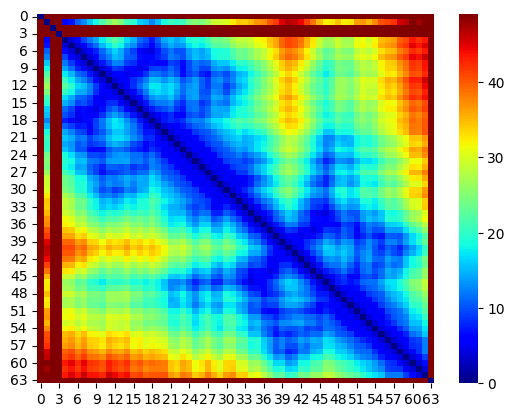

In [76]:
plot_distance_heatmap(dm)

<Axes: >

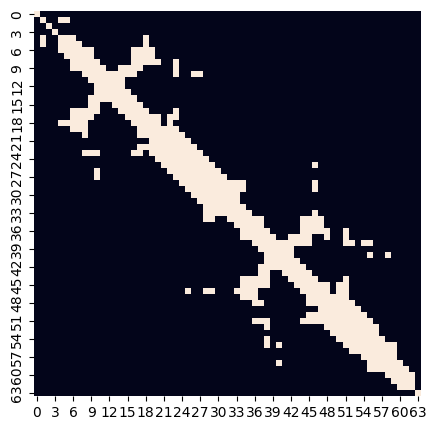

In [77]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, cbar = False)

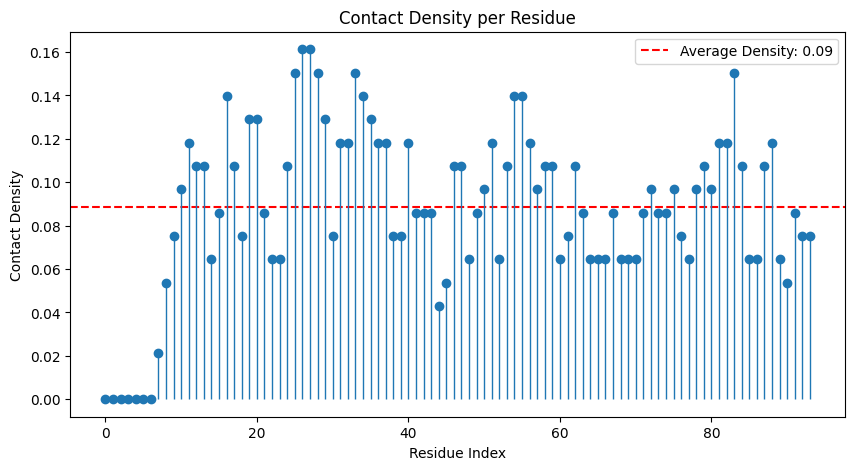

In [25]:
cd_mean = np.mean(cd)
plt.figure(figsize=(10, 5))
plt.scatter(range(seqlength), cd)
plt.axhline(y=cd_mean, color='r', linestyle='--', label=f"Average Density: {cd_mean:.2f}")
plt.vlines(x=range(seqlength), linestyle='-', linewidth=1, ymin=0, ymax=cd)
plt.xlabel("Residue Index")
plt.ylabel("Contact Density")
plt.title("Contact Density per Residue")
plt.legend()
plt.show()

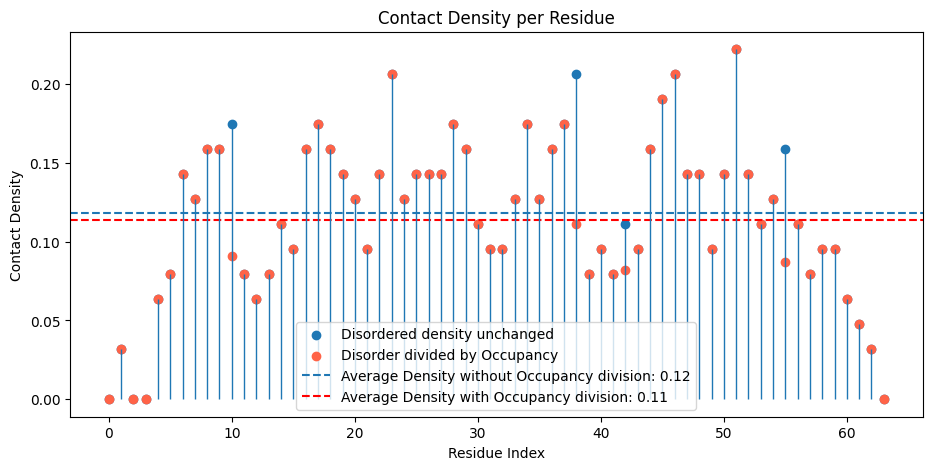

In [97]:
cd_mean = np.mean(cd)
cd_occ_mean = np.mean(cd_occ)
plt.figure(figsize=(11, 5))
plt.scatter(range(seqlength), cd, label="Disordered density unchanged")
plt.scatter(range(seqlength), cd_occ, c="tomato", label="Disorder divided by Occupancy")
plt.axhline(y=cd_mean, linestyle='--', label=f"Average Density without Occupancy division: {cd_mean:.2f}")
plt.axhline(y=cd_occ_mean, color='r', linestyle='--', label=f"Average Density with Occupancy division: {cd_occ_mean:.2f}")
plt.vlines(x=range(seqlength), linestyle='-', linewidth=1, ymin=0, ymax=cd)
plt.xlabel("Residue Index")
plt.ylabel("Contact Density")
plt.title("Contact Density per Residue")
plt.legend()
plt.show()

0.03111416151910318
21
13.25


(2.5, 33.0)

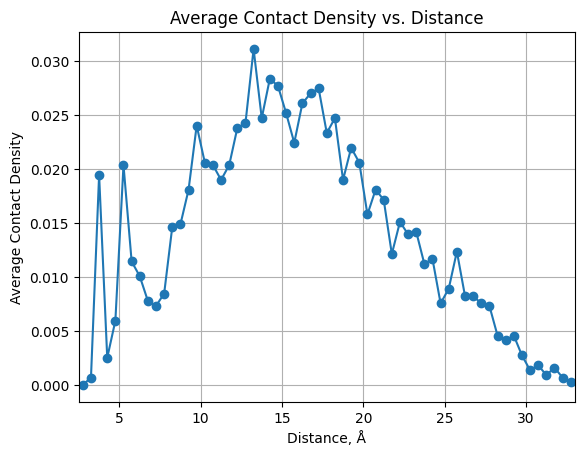

In [245]:
def avg_contact_density(distance_matrix, bin_width=0.5):
  # Extract upper triangular part (excluding diagonal) for efficiency
  mask = np.triu_indices_from(distance_matrix, k=1)
  upper_triangle = distance_matrix[mask]

  bin_centers = np.arange(3, 33 + bin_width/2, bin_width)
  bin_edges = np.concatenate([bin_centers - bin_width/2, [bin_centers[-1] + bin_width/2]])

  counts, _ = np.histogram(upper_triangle, bins=bin_edges)
  bin_edges = bin_edges[:-1]
  # Calculate total number of residue pairs (excluding diagonal)
  total_pairs = distance_matrix.shape[0] * (distance_matrix.shape[0] - 1) / 2

  avg_densities = counts / total_pairs
  return bin_edges, avg_densities

distances, avg_densities = avg_contact_density(dm)


print(avg_densities.max())
print(avg_densities.argmax())
print(distances[avg_densities.argmax()])

#std_dev = np.sqrt(avg_densities)
#plt.errorbar(distances, avg_densities, yerr=std_dev, fmt='o-', capsize=5)
plt.errorbar(distances, avg_densities, fmt='o-', capsize=3)
plt.xlabel("Distance, Å")
plt.ylabel("Average Contact Density")
plt.title("Average Contact Density vs. Distance")
plt.grid(True)
plt.xlim(min(distances) - 0.25, max(distances) + 0.25)  # Adjust x-axis limits for clarity

In [104]:
# print for presentation
#counter_r = 0
counter_ca = 0
for r in model[chain]:
    #counter_r += 1
    for atom in r:
        #if atom.get_name() == "CA":
        if atom.is_disordered() and atom.get_name() == "CA":
            print(atom)
            print(atom.get_occupancy())
            #print(r.get_resname(), atom.get_name(), atom.get_coord())
            #print(r.get_id())
            counter_ca += 1
    #if counter_r >= 100:
    #    break

#print(counter_r)
print(counter_ca)

<DisorderedAtom CA>
0.52
<DisorderedAtom CA>
0.54
<DisorderedAtom CA>
0.74
<DisorderedAtom CA>
0.55
4


In [8]:
import pandas as pd
import numpy as np

data = pd.read_csv("full_filtered.csv")

x = data['PDBchain'].astype(str).map(len)

print(x.value_counts())
print(x.value_counts()/len(x))
print(np.argmax(x))






PDBchain
5    18195
7      107
6       63
8        2
Name: count, dtype: int64
PDBchain
5    0.990635
7    0.005826
6    0.003430
8    0.000109
Name: count, dtype: float64
11486
